In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as plx
from pathlib import Path
from random import random
from datetime import timedelta

from sec import *
from stooq import *

import json
from tqdm.notebook import tqdm

from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Construção da Tabela de Preços

### Aquisição dos dados

#### Preços e macroeconomia

 > O site polonês [Stooq](https://stooq.com/db/h/) ofereçe dados históricos de preços e indicadores macroeconômicos de graça. Não se preocupe, a página não está em Polonês! Basta baixar as tabelas necessárias e organizar os arquivos de acordo com o recomendado no site.

#### Tabela tickers para CIK

> A SEC, comissão de valores mobiliários americana, disponibiliza uma [tabela de tickers para CIK](https://www.sec.gov/file/company-tickers). Este caderno utiliza o CIK como identificador de ativos porque é imutável, ao contrário dos tickers.

#### Fundamentos

> A SEC também disponibilia um grande volume de [dados contábeis](http://www.sec.gov/Archives/edgar/daily-index/xbrl/companyfacts.zip) das companhias publicamente negociadas nos Estados Unidos. Baixe o arquivo ZIP e extraia no diretório indicado &fundamentals_dir& abaixo.

In [3]:
# Altere estas variáveis caso os arquivos não tenham sido encontrados
stooq_dir = 'data/stooq'
fundamentals_dir = 'data/sec/companyfacts'
tickers_path = 'data/sec/company_tickers.json'

In [4]:
period = 'daily'
market = 'us'
sample_companies = [
    'MSFT.US',
    'AVGO.US',
    'NVDA.US',
    'TSM.US',
    'TSLA.US',
    'META.US',
    'IBM.US',
    'AAPL.US',
    'ASML.US',
    'AMZN.US',
    'GOOG.US',
    'LLY.US',
    'WMT.US',
    'JPM.US',
    'V.US',
    'UNH.US',
    'XOM.US',
    'ORCL.US',
    'MA.US'
]

In [5]:
cik_by_ticker = None
with open(tickers_path, 'r') as file:
    cik_by_ticker = json.load(file)
cik_by_ticker = { value['ticker'] + '.US': value['cik_str'] for _key, value in cik_by_ticker.items() }

### Limpeza dos dados

In [6]:
prices = build_prices_table(stooq_dir, period, market)
add_one_cent_noise(prices)

,<TICKER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
6436603,A.US,1999-11-18,0,29.5594,32.4842,25.9889,28.587218,6.886678e+07
6436604,A.US,1999-11-19,0,27.8972,27.9371,25.8613,26.236844,1.677358e+07
6436605,A.US,1999-11-22,0,26.8370,28.5858,26.0278,28.594415,7.242576e+06
6436606,A.US,1999-11-23,0,27.6102,28.3377,25.9889,25.996196,6.579458e+06
6436607,A.US,1999-11-24,0,26.0637,27.2445,25.9889,26.681633,5.332648e+06
...,...,...,...,...,...,...,...,...
13848043,ZZZ.US,2024-05-24,0,25.0800,25.1784,25.0800,25.183622,4.060000e+02
13848044,ZZZ.US,2024-05-28,0,25.0000,25.0100,25.0000,25.015777,2.769000e+03
13848045,ZZZ.US,2024-05-29,0,24.8500,24.8500,24.8359,24.839847,8.910000e+02
13848046,ZZZ.US,2024-05-30,0,24.9700,24.9850,24.8544,24.861806,1.127000e+03


### Criação de variáveis

In [7]:
add_columns_prices(prices)
#prices = pd.read_parquet(Path(f'data/stooq/{period}/{market}/all_stocks_processed.parquet'))
prices.columns = [col[1:-1].lower() for col in prices.columns]
prices['delta_date'] = prices.date - prices.groupby('ticker')['date'].shift()
prices['daily_log_return'] = prices.log_return / prices.delta_date.dt.days

In [8]:
prices['cik'] = prices.ticker.map(cik_by_ticker)
prices.dropna(inplace=True)
prices['cik'] = prices.cik.astype(int)

### Formatação final

In [9]:
prices.drop(columns=['open', 'high', 'low', 'vol', 'delta_date', 'daily_log_return'], inplace=True, errors='ignore')
prices.set_index(['cik', 'date'], inplace=True)
prices.drop_duplicates(inplace=True)

## Contrução da tabela de fundamentos

### Aquisição dos Dados

In [10]:
fundamentals_raw = {
    #'Revenues': ('USD', 'revenue'),
    'NetIncomeLoss': ('USD', 'net_income'),
    #'OperatingExpenses': ('USD', 'op_costs'),
    #'InterestExpense': ('USD', 'interest_paid'),
    #'IncomeTaxesPaidNet': ('USD', 'taxes_paid'),
    'EarningsPerShareDiluted': ('USD/shares', 'eps'),
    #'DepreciationAndAmortization': ('USD', 'deprec_amort'),
    #'CommonStockSharesOutstanding': ('shares', 'share_count')
}
companies = prices.index.get_level_values('cik').unique()
for column_name, (unit, col_alias) in tqdm(fundamentals_raw.items()):
    fundamentals_raw[column_name] = build_fundamental_col(fundamentals_dir, column_name, unit, col_alias, companies)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5719 [00:00<?, ?it/s]

ValueError: No objects to concatenate

In [8]:
fundamentals = fundamentals_raw['NetIncomeLoss']\
    .join(fundamentals_raw['EarningsPerShareDiluted'], how='outer')\
#    .join(fundamentals_raw['Revenues'], how='outer')\
#    .join(fundamentals_raw['OperatingExpenses'], how='outer')\
#    .join(fundamentals_raw['CommonStockSharesOutstanding'], how='outer')


In [9]:
fundamentals.to_parquet('data/sec/fundamentals_processed.parquet')

### Limpeza dos dados

In [9]:
fundamentals = pd.read_parquet('data/sec/fundamentals_processed.parquet')

In [10]:
#fundamentals['revenue'] = fundamentals['revenue'].fillna(fundamentals['op_costs'] + fundamentals['net_income'])
#fundamentals['cost_margin'] = fundamentals['op_costs'] / fundamentals['revenue']
fundamentals['adj_factor'] = (fundamentals['net_income'] / fundamentals['eps'])
fundamentals['eps_adj_factor'] = fundamentals['adj_factor'] / fundamentals['adj_factor'].groupby(level='cik').last()
#fundamentals['rps'] = fundamentals['revenue'] / fundamentals['adj_factor']
fundamentals['eps'] = fundamentals['eps'] * fundamentals['eps_adj_factor']
fundamentals = fundamentals[['eps']]

### Criação de variáveis

In [11]:
fundamentals.sort_index(inplace=True)
fundamentals = {'lag_0': fundamentals}
for i in range(1, 5):
    fundamentals[f'lag_{i}'] = fundamentals[f'lag_{i-1}'].groupby(level='cik').shift()

In [12]:
fundamentals = pd.concat(fundamentals, axis='columns')
rename_map = {
    'filed': 'date', 
    #'val_eps': 'eps', 
    #'val': 'op_costs', 
    #'val_interest': 'interest_paid', 
    #'val_taxes': 'taxes_paid',
    #'val_deprec_amort': 'deprec_amort',
}
fundamentals = fundamentals.reset_index().rename(rename_map, axis='columns').set_index(['cik', 'date'])
fundamentals.columns = [f'{col}_{lag}' for lag, col in fundamentals.columns]

In [13]:
fundamentals['eps_moving_sum'] = fundamentals.eps_lag_0 + fundamentals.eps_lag_1 + fundamentals.eps_lag_2 + fundamentals.eps_lag_3
fundamentals['eps_growth'] = fundamentals.eps_lag_0 / fundamentals.eps_lag_4

## Construção da tabela final

In [14]:
final_table = prices.merge(fundamentals, 'outer', left_index=True, right_index=True)
final_table.sort_index(inplace=True)
final_table.iloc[:,5:] = final_table.iloc[:,5:].groupby(level='cik').ffill(limit=65)

### Criação de variáveis

#### Earnings yield ajustado

Trata-se do $earnings\_yield + 1$. Foi escolhida esta métrica pelos seguintes motivos:
 - Raramente dá valores negativos, o que permite o processamento em escala logarítmica;
 - Depende de dois dados relativamente fáceis de obter: o preço e o EPS;
 - É relativamente estável no tempo;

In [15]:
final_table['yesterday_close'] = final_table['close'].groupby(level='cik').shift()
final_table['log_yday_close'] = np.log(final_table['yesterday_close'])

final_table[f'adj_ey_ms'] = 1 + (final_table[f'eps_moving_sum'] / final_table['yesterday_close'])
final_table[f'log_adj_ey_ms'] = np.log(final_table[f'adj_ey_ms'])

final_table[f'adj_ey_delta'] = 1 + (final_table[f'eps_growth'] / final_table['yesterday_close'])
final_table[f'log_adj_ey_delta'] = np.log(final_table[f'adj_ey_delta'])

/home/pedro/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pedro/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
final_table['log_adj_ey_l1'] = final_table['log_adj_ey_ms'] - final_table['log_adj_ey_ms'].groupby('cik').shift()
final_table['log_adj_ey_l2'] = final_table['log_adj_ey_l1'] - final_table['log_adj_ey_l1'].groupby('cik').shift()

In [17]:
interest_rate = pd.read_csv(f'{stooq_dir}/daily/macro/us/inrtus.m.txt')
interest_rate = interest_rate[['<DATE>', '<CLOSE>']].copy()

In [18]:
interest_rate.rename(columns={'<DATE>': 'date', '<CLOSE>': 'interest'}, inplace=True) 
interest_rate['date'] = pd.to_datetime(interest_rate['date'].astype(str))
interest_rate.set_index('date', inplace=True)
interest_rate.sort_index(inplace=True)
final_table = final_table.join(interest_rate, how='left')

In [19]:
final_table['interest'] = final_table['interest'].groupby(level='cik').ffill()
final_table['interest'] = 1 + (final_table.interest / 100)
final_table['log_interest'] = np.log(final_table.interest)

### Limpeza final

In [20]:
final_table = final_table.replace([-np.inf, np.inf], np.nan)
final_table = final_table[['ticker', 'log_close', 'log_return', 'log_yday_close', 'log_adj_ey_ms', 'log_adj_ey_l1', 'log_adj_ey_l2', 'log_interest', 'eps_moving_sum']]
final_table.to_parquet('data/final_table.parquet')
final_table

ticker  log_close  log_return  log_yday_close  \
cik     date                                                          
1750    2005-02-28    AIR.US   2.307446   -0.025424             NaN   
        2005-03-01    AIR.US   2.360316    0.052871        2.307446   
        2005-03-02    AIR.US   2.347999   -0.012318        2.360316   
        2005-03-03    AIR.US   2.346812   -0.001187        2.347999   
        2005-03-04    AIR.US   2.390784    0.043972        2.346812   
...                      ...        ...         ...             ...   
2012807 2024-05-24  RFAIU.US   2.311411    0.002199        2.309211   
        2024-05-28  RFAIU.US   2.308905   -0.002506        2.311411   
        2024-05-29  RFAIU.US   2.308589   -0.000317        2.308905   
        2024-05-30  RFAIU.US   2.310208    0.001619        2.308589   
        2024-05-31  RFAIU.US   2.311029    0.000821        2.310208   

                    log_adj_ey_ms  log_adj_ey_l1  log_adj_ey_l2  log_interest  \
cik     date                                                                    
1750    2005-02-28            NaN            NaN            NaN           NaN   
        2005-03-01            NaN            NaN            NaN           NaN   
        2005-03-02            NaN            NaN            NaN           NaN   
        2005-03-03            NaN            NaN            NaN           NaN   
        2005-03-04            NaN            NaN            NaN           NaN   
...                           ...            ...            ...           ...   
2012807 2024-05-24            NaN            NaN            NaN           NaN   
        2024-05-28            NaN            NaN            NaN           NaN   
        2024-05-29            NaN            NaN            NaN           NaN   
        2024-05-30            NaN            NaN            NaN           NaN   
        2024-05-31            NaN            NaN            NaN           NaN   

                    eps_moving_sum  
cik     date                        
1750    2005-02-28             NaN  
        2005-03-01             NaN  
        2005-03-02             NaN  
        2005-03-03             NaN  
        2005-03-04             NaN  
...                            ...  
2012807 2024-05-24             NaN  
        2024-05-28             NaN  
        2024-05-29             NaN  
        2024-05-30             NaN  
        2024-05-31             NaN  

[17600062 rows x 9 columns]

## Treinamento do modelo

In [21]:
final_table = pd.read_parquet('data/final_table.parquet')

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [23]:
sample_ciks = [cik_by_ticker[ticker] for ticker in ['LLY.US']]
sample_table = final_table[final_table.index.get_level_values('cik').isin(sample_ciks)].dropna()

In [24]:
#sample_table = final_table.dropna()

Para ver o que acontece quando incluimos todas as empresas no modelo, descomente a célula acima e comenta a anterior.

### Exploração de dados

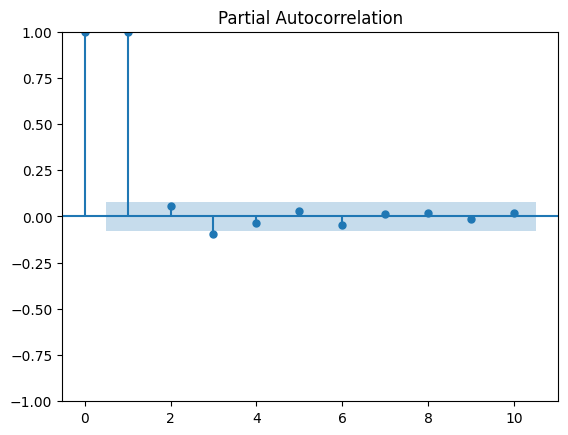

In [25]:
pacf = plot_pacf(sample_table['log_adj_ey_ms'], lags=10)

No gráfico de autocorrelação parcial, podemos ver que apenas um lag do earnings yield ajustado tem correlação com a variável final. 

In [26]:
sample_table[['log_adj_ey_ms', 'log_adj_ey_l1', 'log_adj_ey_l2', 'log_interest']].corr()

,log_adj_ey_ms,log_adj_ey_l1,log_adj_ey_l2,log_interest
log_adj_ey_ms,1.000000,0.042986,0.005917,-0.609969
log_adj_ey_l1,0.042986,1.000000,0.745573,0.007537
log_adj_ey_l2,0.005917,0.745573,1.000000,-0.001898
log_interest,-0.609969,0.007537,-0.001898,1.000000


Além disso, l1 e l2 são extremamente correlatos! Isso quer dizer que manter os dois só deixaria o modelo mais complexo.

### Treinamento de um modelo

In [27]:
model = smf.ols('log_return ~ log_adj_ey_ms + log_adj_ey_l1 + log_interest', data=sample_table).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.569
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.196
Time:                        15:02:37   Log-Likelihood:                 1755.8
No. Observations:                 655   AIC:                            -3504.
Df Residuals:                     651   BIC:                            -3486.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0009      0.003      0.314      0.754      -0.005       0.007
log_adj_ey_ms    -0.0077      0.090     -0.086      0.931      -0.184       0.168
log_adj_ey_l1     2.8644      1.322      2.167      0.031       0.269       5.459
log_interest     -0.0086      0.064     -0.134      0.894      -0.134       0.117
==============================================================================
Omnibus:                      114.425   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1567.235
Skew:                           0.267   Prob(JB):                         0.00
Kurtosis:                      10.559   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

O único coeficiente significativo parece ser o lag 1 do earnings yield ajustado!

In [28]:
sample_table.dropna(inplace=True)
sample_table['predictions'] = model.predict()
comparison = pd.DataFrame({
    'random_walk': sample_table.log_return,
    'markov_chain': sample_table.log_return - sample_table.predictions,
}).dropna()

Abaixo, temos a comparação de duas premissas: 
- A Random Walk, que presume que a mehlor previsão do retorno é 0;
- A Cadeia de Markov, que presume que a tendência do retorno é previsível por meio de variáveis ocultas;

In [29]:
plx.histogram(
    data_frame=comparison.melt(),
    title='Comparação de resíduos - Modelo vs Random walk',
    x='value',
    color='variable',
    barmode='overlay',
    nbins=512,
    height=720,
    width=1280,
)

/home/pedro/.local/lib/python3.10/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


Parece que a cadeia de Markov com nosso indicador teve um desempenho similar à Random Walk. Isso é um mal sinal!

## Avaliação do modelo

Agora, vamos verificar como o modelo se comporta com dados fora de amostra.

In [30]:
from datetime import datetime

### Divisão em treino e teste

In [31]:
company = 'LLY.US'
split_date = datetime(2020, 6, 1)

company_data = final_table.loc[cik_by_ticker[company]]
company_train = company_data[company_data.index <= split_date].dropna()
company_test = company_data[company_data.index > split_date].dropna()

### Treinamento na base de treino

In [1]:
model = smf.ols('log_return ~ log_adj_ey_ms', data=company_train).fit()
model.summary()

NameError: name 'smf' is not defined

### Geração de Previsões

In [33]:
company_test['predictions'] = model.predict(company_test)
company_test['model_error'] = company_test['predictions'] - company_test['log_return']

### Vizualização dos resíduos

In [34]:
plx.histogram(
    data_frame=company_test[['log_return', 'model_error']].melt(),
    title='Comparação de erros - Modelo vs Random walk',
    x='value',
    color='variable',
    barmode='overlay',
    nbins=128,
    height=720,
    width=1280,
)

/home/pedro/.local/lib/python3.10/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



O desempenho na base de testes consegue ser ainda pior!

### R-quadrado do modelo

In [35]:
from sklearn.metrics import r2_score

In [36]:
r2_score(company_test.log_return, company_test.predictions)

-0.8447865040825222

In [37]:
qq_data = company_test[['log_return', 'model_error']]

### Quantile-Quantile Plot

array([<Axes: title={'center': 'Log of Returns'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
       <Axes: title={'center': 'Model Error'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>],
      dtype=object)

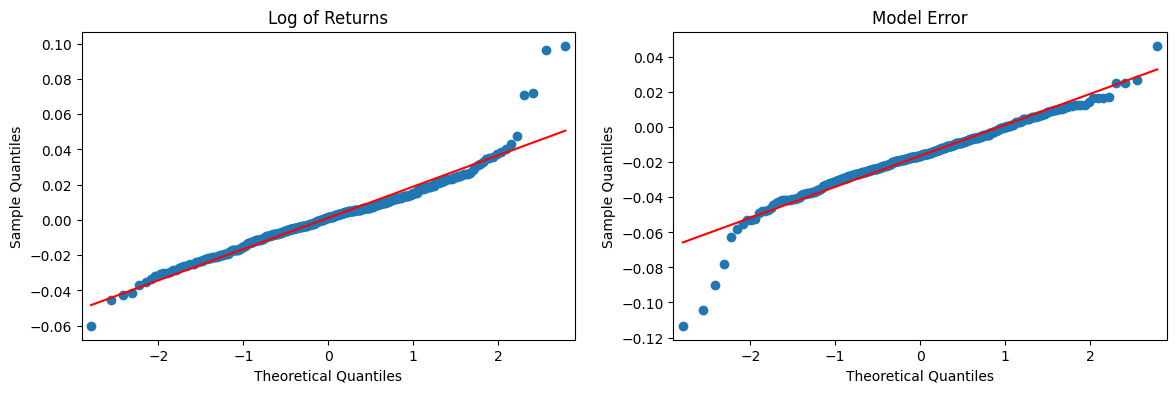

In [38]:

fig, ax = plt.subplots(figsize = (14,4), ncols=2)

sm.qqplot(qq_data['log_return'], line='s',ax = ax[0])
sm.qqplot(qq_data['model_error'], line='s',ax = ax[1])

ax[0].set_title('Log of Returns')
ax[1].set_title('Model Error')

ax

Observe que a distribuição dos erros é parecida com a normal entre -2 e 2 desvios padrão, apenas. Portanto, não podemos presumir a normalidade da distribuição dos erros

### Simulação

Aqui, simulamos um robô negociador que teria comprado ações nos dias em que o modelo desse positivo e vendido nos dias em que o modelo desse negativo. Note que isto não é um conselho financeiro!

In [39]:
np.exp(company_test.model_error.mean())

0.9838107173578444

In [40]:
model_return = ((company_test.predictions > 0).astype(int) * company_test.log_return).cumsum()
buy_hold_return = company_test.log_return.cumsum()
simulation = pd.DataFrame({
    'model_return': model_return,
    'buy_hold_return': buy_hold_return,
})

In [41]:
simulation

,model_return,buy_hold_return
date,,
2021-05-04,0.0,0.012222
2021-05-05,0.0,0.036362
2021-05-06,0.0,0.042032
2021-05-07,0.0,0.049841
2021-05-10,0.0,0.046443
...,...,...
2023-01-31,0.0,0.470520
2023-02-01,0.0,0.465923
2023-02-02,0.0,0.430654


In [42]:
simulation = np.exp(simulation)

In [1]:
plx.line(
    data_frame=simulation.melt(ignore_index=False).reset_index(),
    title='Cummulative returns - Model vs Buy and hold',
    x='date',
    y='value',
    color='variable',
    log_y=True
)

NameError: name 'plx' is not defined

> Note that data is missing between February and April 2022.

## Conclusão

A métrica proposta, $log(1 + \frac{eps}{price _{i-1}})$ não é um bom preditor para o retorno diário das empresas. O que é uma pena pois, tem progressão aritimética, tal qual $log(price)$, raramente resulta em logarítimos negativos e é baseada numa métrica relativamente fácil de conseguir, o $EPS$. Talvez tenhamos resultados melhores trabalhando com resoluções diferentes ou prevendo retornos em períodos maiores, como o trimestral.